In [1]:
!pip install lap
# Read the dataset description
import gzip
# Read or generate p2h, a dictionary of image name to image id (picture to hash)
import pickle
import platform
import random
# Suppress annoying stderr output when importing keras.
import sys
from lap import lapjv
from math import sqrt
# Determine the size of each image
from os.path import isfile

import keras
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image as pil_image
from imagehash import phash
from keras import backend as K
from keras import regularizers
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, \
    Lambda, MaxPooling2D, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import Sequence
from pandas import read_csv
from scipy.ndimage import affine_transform
from tqdm import tqdm_notebook as tqdm
import time

%matplotlib inline

    100% |████████████████████████████████| 1.5MB 18.6MB/s ta 0:00:01
  Stored in directory: /tmp/.cache/pip/wheels/da/3e/af/eddcd6ffaa27df8d0ddac573758f8953c4e57c64c4c8c8b7d0
Successfully built lap
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


Data Analysis for the set¶

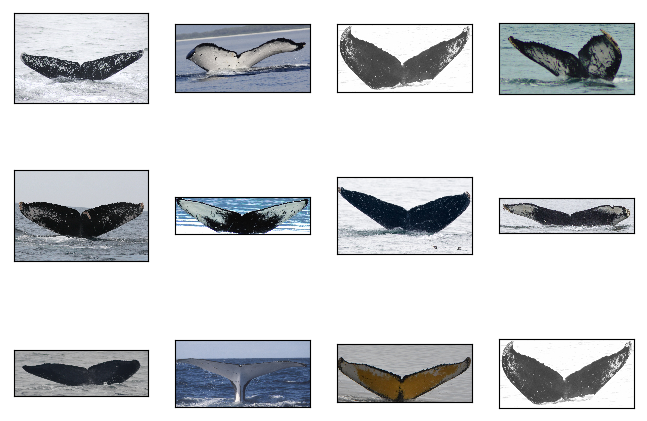

In [2]:
import os
fig = plt.figure(figsize=(8, 8), dpi=100,facecolor='w', edgecolor='k')
train_imgs = os.listdir("../input/humpback-whale-identification/train")
for idx, img in enumerate(np.random.choice(train_imgs, 12)):
    ax = fig.add_subplot(4, 20//5, idx+1, xticks=[], yticks=[])
    im = pil_image.open("../input/humpback-whale-identification/train/" + img)
    plt.imshow(im)

In [3]:
# load image data
#image name
df = pd.read_csv('../input/humpback-whale-identification/train.csv')
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [4]:
print(f'Training examples: {len(df)}')
print("Unique whales: ",df['Id'].nunique()) # it includes new_whale as a separate type.
training_pts_per_class = df.groupby('Id').size()
print("Min example a class can have: ",training_pts_per_class.min())
print("0.99 quantile: ",training_pts_per_class.quantile(0.99))
print("Max example a class can have: \n",training_pts_per_class.nlargest(2)) 

Training examples: 25361
Unique whales:  5005
Min example a class can have:  1
0.99 quantile:  22.0
Max example a class can have: 
 Id
new_whale    9664
w_23a388d      73
dtype: int64


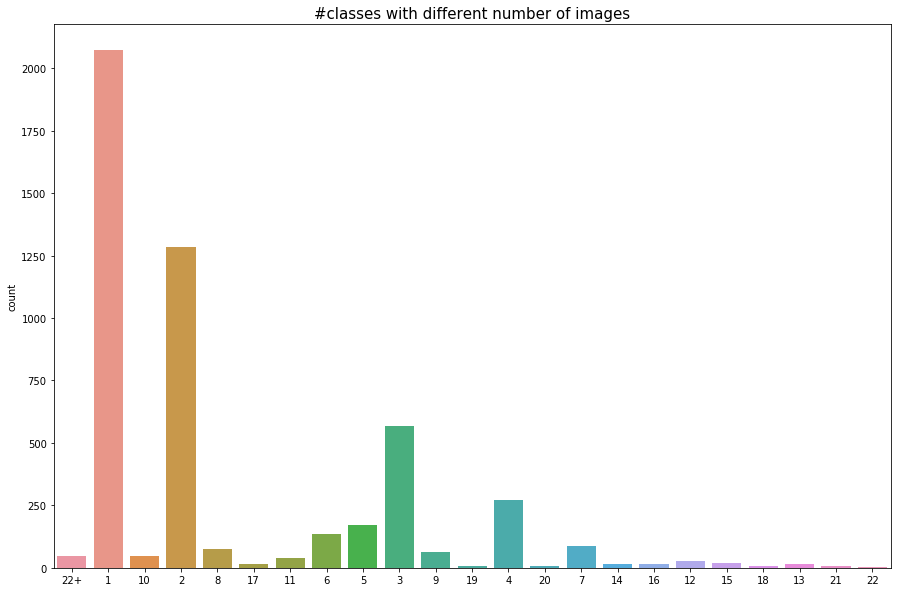

In [5]:
data = training_pts_per_class.copy()
data.loc[data > data.quantile(0.99)] = '22+'
plt.figure(figsize=(15,10))
sns.countplot(data.astype('str'))
plt.title("#classes with different number of images",fontsize=15)
plt.show()

Based on SNN with limited computing resources¶
The basic idea to solve the problem besed on SNN structure is in order to deal with highly unbanlenced dataset -- class 0 has more than a half of the pics in the whole dataset.

We are just using the pretrained weights from @martinpiotte.

We keep the basic structure of the Siamese (pretrained) 0.822 kernel, but we change the input as the RGB channels. And for the epochs , we narrow its number to 20 in this kernel for every model, but we use the pretrained weight to do the warm initialization.

We also get generated bounding boxes from this kernel here which saved as a .csv instead of pickle for readability.

In [6]:
TRAIN_DF = '../input/humpback-whale-identification/train.csv'
SUB_Df = '../input/humpback-whale-identification/sample_submission.csv'
TRAIN = '../input/humpback-whale-identification/train/'
TEST = '../input/humpback-whale-identification/test/'
P2H = '../input/metadata/p2h.pickle'
P2SIZE = '../input/metadata/p2size.pickle'
BB_DF = "../input/metadata/bounding_boxes.csv"
tagged = dict([(p, w) for _, p, w in read_csv(TRAIN_DF).to_records()])
submit = [p for _, p, _ in read_csv(SUB_Df).to_records()]
join = list(tagged.keys()) + submit

## Duplicate image identification
This part was from the original kernel, seems like in the playground competition dulicated images was a real issue. I don't know the case about this one but I took one for the team and generated the results anyway. I'm such a nice chap.

In [7]:
def expand_path(p):
    if isfile(TRAIN + p):
        return TRAIN + p
    if isfile(TEST + p):
        return TEST + p
    return p

if isfile(P2SIZE):
    print("P2SIZE exists.")
    with open(P2SIZE, 'rb') as f:
        p2size = pickle.load(f)
else:
    p2size = {}
    for p in tqdm(join):
        size = pil_image.open(expand_path(p)).size
        p2size[p] = size

P2SIZE exists.


In [8]:
def match(h1, h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 = pil_image.open(expand_path(p1))
            i2 = pil_image.open(expand_path(p2))
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1 / sqrt((a1 ** 2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2 / sqrt((a2 ** 2).mean())
            a = ((a1 - a2) ** 2).mean()
            if a > 0.1: return False
    return True


if isfile(P2H):
    print("P2H exists.")
    with open(P2H, 'rb') as f:
        p2h = pickle.load(f)
else:
    # Compute phash for each image in the training and test set.
    p2h = {}
    for p in tqdm(join):
        img = pil_image.open(expand_path(p))
        h = phash(img)
        p2h[p] = h
    # Find all images associated with a given phash value.
    h2ps = {}
    for p, h in p2h.items():
        if h not in h2ps: h2ps[h] = []
        if p not in h2ps[h]: h2ps[h].append(p)

    # Find all distinct phash values
    hs = list(h2ps.keys())

    # If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
    h2h = {}
    for i, h1 in enumerate(tqdm(hs)):
        for h2 in hs[:i]:
            if h1 - h2 <= 6 and match(h1, h2):
                s1 = str(h1)
                s2 = str(h2)
                if s1 < s2: s1, s2 = s2, s1
                h2h[s1] = s2
    # Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
    for p, h in p2h.items():
        h = str(h)
        if h in h2h: h = h2h[h]
        p2h[p] = h
#     with open(P2H, 'wb') as f:
#         pickle.dump(p2h, f)
# For each image id, determine the list of pictures
h2ps = {}
for p, h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)

P2H exists.


In [9]:
def show_whale(imgs, per_row=2):
    n = len(imgs)
    rows = (n + per_row - 1) // per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows, cols, figsize=(24 // per_row * cols, 24 // per_row * rows))
    for ax in axes.flatten(): ax.axis('off')
    for i, (img, ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))
        

def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    return img

In [10]:
# For each images id, select the prefered image
def prefer(ps):
    if len(ps) == 1: return ps[0]
    best_p = ps[0]
    best_s = p2size[best_p]
    for i in range(1, len(ps)):
        p = ps[i]
        s = p2size[p]
        if s[0] * s[1] > best_s[0] * best_s[1]:  # Select the image with highest resolution
            best_p = p
            best_s = s
    return best_p

h2p = {}
for h, ps in h2ps.items():
    h2p[h] = prefer(ps)
len(h2p), list(h2p.items())[:5]

(33317,
 [('d26698c3271c757c', '0000e88ab.jpg'),
  ('ba8cc231ad489b77', '0001f9222.jpg'),
  ('bbcad234a52d0f0b', '00029d126.jpg'),
  ('c09ae7dc09f33a29', '00050a15a.jpg'),
  ('d02f65ba9f74a08a', '0005c1ef8.jpg')])

In [11]:
# Read the bounding box data from the bounding box kernel (see reference above)
p2bb = pd.read_csv(BB_DF).set_index("Image")

old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')

sys.stderr = old_stderr

img_shape = (384, 384, 1)  # The image shape used by the model
anisotropy = 2.15  # The horizontal compression ratio
crop_margin = 0.05  # The margin added around the bounding box to compensate for bounding box inaccuracy

In [12]:
def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    """
    Build a transformation matrix with the specified characteristics.
    """
    rotation = np.deg2rad(rotation)
    shear = np.deg2rad(shear)
    rotation_matrix = np.array(
        [[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix = np.array([[1.0 / height_zoom, 0, 0], [0, 1.0 / width_zoom, 0], [0, 0, 1]])
    shift_matrix = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

In [13]:
def read_cropped_image(p, augment):
    """
    @param p : the name of the picture to read
    @param augment: True/False if data augmentation should be performed
    @return a numpy array with the transformed image
    """
    # If an image id was given, convert to filename
    if p in h2p:
        p = h2p[p]
    size_x, size_y = p2size[p]

    # Determine the region of the original image we want to capture based on the bounding box.
    row = p2bb.loc[p]
    x0, y0, x1, y1 = row['x0'], row['y0'], row['x1'], row['y1']
    dx = x1 - x0
    dy = y1 - y0
    x0 -= dx * crop_margin
    x1 += dx * crop_margin + 1
    y0 -= dy * crop_margin
    y1 += dy * crop_margin + 1
    if x0 < 0:
        x0 = 0
    if x1 > size_x:
        x1 = size_x
    if y0 < 0:
        y0 = 0
    if y1 > size_y:
        y1 = size_y
    dx = x1 - x0
    dy = y1 - y0
    if dx > dy * anisotropy:
        dy = 0.5 * (dx / anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx = 0.5 * (dy * anisotropy - dx)
        x0 -= dx
        x1 += dx
        
    # Generate the transformation matrix
    trans = np.array([[1, 0, -0.5 * img_shape[0]], [0, 1, -0.5 * img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0) / img_shape[0], 0, 0], [0, (x1 - x0) / img_shape[1], 0], [0, 0, 1]]), trans)
    if augment:
        trans = np.dot(build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.8, 1.0),
            random.uniform(0.8, 1.0),
            random.uniform(-0.05 * (y1 - y0), 0.05 * (y1 - y0)),
            random.uniform(-0.05 * (x1 - x0), 0.05 * (x1 - x0))
        ), trans)
    trans = np.dot(np.array([[1, 0, 0.5 * (y1 + y0)], [0, 1, 0.5 * (x1 + x0)], [0, 0, 1]]), trans)

    # Read the image, transform to black and white and comvert to numpy array
    img = read_raw_image(p).convert('L')
    img = img_to_array(img)

    # Apply affine transformation
    matrix = trans[:2, :2]
    offset = trans[:2, 2]
    img = img.reshape(img.shape[:-1])
    img = affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant',
                           cval=np.average(img))
    img = img.reshape(img_shape)

    # Normalize to zero mean and unit variance
    img -= np.mean(img, keepdims=True)
    img /= np.std(img, keepdims=True) + K.epsilon()
    return img

def read_for_training(p):
    """
    Read and preprocess an image with data augmentation (random transform).
    """
    return read_cropped_image(p, True)


def read_for_validation(p):
    """
    Read and preprocess an image without data augmentation (use for testing).
    """
    return read_cropped_image(p, False)


p = list(tagged.keys())[312]
print(p)

031b230c7.jpg


In [14]:
# # Dependent for SNN Model structure
# from keras import backend as K
# from keras import regularizers
# from keras.applications.xception import Xception
# from keras.applications.densenet import DenseNet121, DenseNet169
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.mobilenet import MobileNet
# from keras.applications.resnet50 import ResNet50
# from keras.applications.nasnet import NASNetMobile
# from keras.engine.topology import Input
# from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, \
#     Lambda, MaxPooling2D, Reshape, GlobalAveragePooling2D
# from keras.models import Model
# from keras.optimizers import Adam


In [15]:
# Here we only should the self-designed cnn layers, the Pretrained layers like dense121 are well packaged.
def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y)  # Reduce the number of features to 'filter'
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y)  # Extend the feature field
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y)  # no activation # Restore the number of original features
    y = Add()([x, y])  # Add the bypass connection
    y = Activation('relu')(y)
    return y


def build_model(lr, l2, activation='sigmoid'):
    ##############
    # BRANCH MODEL
    ##############
    regul = regularizers.l2(l2)
    optim = Adam(lr=lr)
    kwargs = {'padding': 'same', 'kernel_regularizer': regul}

    inp = Input(shape=img_shape)  # 384x384x1
    x = Conv2D(64, (9, 9), strides=2, activation='relu', **kwargs)(inp)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 96x96x64
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1, 1), activation='relu', **kwargs)(x)  # 48x48x128
    for _ in range(4):
        x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 24x24x128
    x = BatchNormalization()(x)
    x = Conv2D(256, (1, 1), activation='relu', **kwargs)(x)  # 24x24x256
    for _ in range(4):
        x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 12x12x256
    x = BatchNormalization()(x)
    x = Conv2D(384, (1, 1), activation='relu', **kwargs)(x)  # 12x12x384
    for _ in range(4):
        x = subblock(x, 96, **kwargs)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1, 1), activation='relu', **kwargs)(x)  # 6x6x512
    for _ in range(4):
        x = subblock(x, 128, **kwargs)

    x = GlobalMaxPooling2D()(x)  # 512
    branch_model = Model(inp, x)

    ############
    # HEAD MODEL
    ############
    mid = 32
    xa_inp = Input(shape=branch_model.output_shape[1:])
    xb_inp = Input(shape=branch_model.output_shape[1:])
    x1 = Lambda(lambda x: x[0] * x[1])([xa_inp, xb_inp])
    x2 = Lambda(lambda x: x[0] + x[1])([xa_inp, xb_inp])
    x3 = Lambda(lambda x: K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4 = Lambda(lambda x: K.square(x))(x3)
    x = Concatenate()([x1, x2, x3, x4])
    x = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # Per feature NN with shared weight is implemented using CONV2D with appropriate stride.
    x = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x = Flatten(name='flatten')(x)

    # Weighted sum implemented as a Dense layer.
    x = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # Complete model is constructed by calling the branch model on each input image,
    # and then the head model on the resulting 512-vectors.
    img_a = Input(shape=img_shape)
    img_b = Input(shape=img_shape)
    xa = branch_model(img_a)
    xb = branch_model(img_b)
    x = head_model([xa, xb])
    model = Model([img_a, img_b], x)
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model

model, branch_model, head_model = build_model(64e-5, 0)

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
h2ws = {}
new_whale = 'new_whale'
for p, w in tagged.items():
    if w != new_whale:  # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h, ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)

# For each whale, find the unambiguous images ids.
w2hs = {}
for h, ws in h2ws.items():
    if len(ws) == 1:  # Use only unambiguous pictures
        w = ws[0]
        if w not in w2hs: w2hs[w] = []
        if h not in w2hs[w]: w2hs[w].append(h)
for w, hs in w2hs.items():
    if len(hs) > 1:
        w2hs[w] = sorted(hs)

In [17]:
train = []  # A list of training image ids
for hs in w2hs.values():
    if len(hs) > 1:
        train += hs
random.shuffle(train)
train_set = set(train)

w2ts = {}  # Associate the image ids from train to each whale id.
for w, hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts:
                w2ts[w] = []
            if h not in w2ts[w]:
                w2ts[w].append(h)
for w, ts in w2ts.items():
    w2ts[w] = np.array(ts)

t2i = {}  # The position in train of each training image id
for i, t in enumerate(train):
    t2i[t] = i

In [18]:
class TrainingData(Sequence):
    def __init__(self, score, steps=1000, batch_size=32):
        """
        @param score the cost matrix for the picture matching
        @param steps the number of epoch we are planning with this score matrix
        """
        super(TrainingData, self).__init__()
        self.score = -score  # Maximizing the score is the same as minimuzing -score.
        self.steps = steps
        self.batch_size = batch_size
        for ts in w2ts.values():
            idxs = [t2i[t] for t in ts]
            for i in idxs:
                for j in idxs:
                    self.score[
                        i, j] = 10000.0  # Set a large value for matching whales -- eliminates this potential pairing
        self.on_epoch_end()

    def __getitem__(self, index):
        start = self.batch_size * index
        end = min(start + self.batch_size, len(self.match) + len(self.unmatch))
        size = end - start
        assert size > 0
        a = np.zeros((size,) + img_shape, dtype=K.floatx())
        b = np.zeros((size,) + img_shape, dtype=K.floatx())
        c = np.zeros((size, 1), dtype=K.floatx())
        j = start // 2
        for i in range(0, size, 2):
            a[i, :, :, :] = read_for_training(self.match[j][0])
            b[i, :, :, :] = read_for_training(self.match[j][1])
            c[i, 0] = 1  # This is a match
            a[i + 1, :, :, :] = read_for_training(self.unmatch[j][0])
            b[i + 1, :, :, :] = read_for_training(self.unmatch[j][1])
            c[i + 1, 0] = 0  # Different whales
            j += 1
        return [a, b], c

    def on_epoch_end(self):
        if self.steps <= 0: return  # Skip this on the last epoch.
        self.steps -= 1
        self.match = []
        self.unmatch = []
        _, _, x = lapjv(self.score)  # Solve the linear assignment problem
        y = np.arange(len(x), dtype=np.int32)

        # Compute a derangement for matching whales
        for ts in w2ts.values():
            d = ts.copy()
            while True:
                random.shuffle(d)
                if not np.any(ts == d): break
            for ab in zip(ts, d): self.match.append(ab)

        # Construct unmatched whale pairs from the LAP solution.
        for i, j in zip(x, y):
            if i == j:
                print(self.score)
                print(x)
                print(y)
                print(i, j)
            assert i != j
            self.unmatch.append((train[i], train[j]))

        # Force a different choice for an eventual next epoch.
        self.score[x, y] = 10000.0
        self.score[y, x] = 10000.0
        random.shuffle(self.match)
        random.shuffle(self.unmatch)
        # print(len(self.match), len(train), len(self.unmatch), len(train))
        assert len(self.match) == len(train) and len(self.unmatch) == len(train)

    def __len__(self):
        return (len(self.match) + len(self.unmatch) + self.batch_size - 1) // self.batch_size

# Test on a batch of 32 with random costs.
score = np.random.random_sample(size=(len(train), len(train)))
data = TrainingData(score)
(a, b), c = data[0]

In [19]:
# A Keras generator to evaluate only the BRANCH MODEL
class FeatureGen(Sequence):
    def __init__(self, data, batch_size=64, verbose=1):
        super(FeatureGen, self).__init__()
        self.data = data
        self.batch_size = batch_size
        self.verbose = verbose
        if self.verbose > 0: self.progress = tqdm(total=len(self), desc='Features')

    def __getitem__(self, index):
        start = self.batch_size * index
        size = min(len(self.data) - start, self.batch_size)
        a = np.zeros((size,) + img_shape, dtype=K.floatx())
        for i in range(size): a[i, :, :, :] = read_for_validation(self.data[start + i])
        if self.verbose > 0:
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return a

    def __len__(self):
        return (len(self.data) + self.batch_size - 1) // self.batch_size

class ScoreGen(Sequence):
    def __init__(self, x, y=None, batch_size=2048, verbose=1):
        super(ScoreGen, self).__init__()
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.verbose = verbose
        if y is None:
            self.y = self.x
            self.ix, self.iy = np.triu_indices(x.shape[0], 1)
        else:
            self.iy, self.ix = np.indices((y.shape[0], x.shape[0]))
            self.ix = self.ix.reshape((self.ix.size,))
            self.iy = self.iy.reshape((self.iy.size,))
        self.subbatch = (len(self.x) + self.batch_size - 1) // self.batch_size
        if self.verbose > 0:
            self.progress = tqdm(total=len(self), desc='Scores')

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min(start + self.batch_size, len(self.ix))
        a = self.y[self.iy[start:end], :]
        b = self.x[self.ix[start:end], :]
        if self.verbose > 0:
            self.progress.update()
            if self.progress.n >= len(self): self.progress.close()
        return [a, b]

    def __len__(self):
        return (len(self.ix) + self.batch_size - 1) // self.batch_size

In [20]:
def set_lr(model, lr):
    K.set_value(model.optimizer.lr, float(lr))


def get_lr(model):
    return K.get_value(model.optimizer.lr)


def score_reshape(score, x, y=None):
    """
    Tranformed the packed matrix 'score' into a square matrix.
    @param score the packed matrix
    @param x the first image feature tensor
    @param y the second image feature tensor if different from x
    @result the square matrix
    """
    if y is None:
        # When y is None, score is a packed upper triangular matrix.
        # Unpack, and transpose to form the symmetrical lower triangular matrix.
        m = np.zeros((x.shape[0], x.shape[0]), dtype=K.floatx())
        m[np.triu_indices(x.shape[0], 1)] = score.squeeze()
        m += m.transpose()
    else:
        m = np.zeros((y.shape[0], x.shape[0]), dtype=K.floatx())
        iy, ix = np.indices((y.shape[0], x.shape[0]))
        ix = ix.reshape((ix.size,))
        iy = iy.reshape((iy.size,))
        m[iy, ix] = score.squeeze()
    return m


def compute_score(verbose=1):
    """
    Compute the score matrix by scoring every pictures from the training set against every other picture O(n^2).
    """
    features = branch_model.predict_generator(FeatureGen(train, verbose=verbose), max_queue_size=12, workers=6,
                                              verbose=0)
    score = head_model.predict_generator(ScoreGen(features, verbose=verbose), max_queue_size=12, workers=6, verbose=0)
    score = score_reshape(score, features)
    return features, score
def make_steps(step, ampl):
    """
    Perform training epochs
    @param step Number of epochs to perform
    @param ampl the K, the randomized component of the score matrix.
    """
    global w2ts, t2i, steps, features, score, histories

    # shuffle the training pictures
    random.shuffle(train)

    # Map whale id to the list of associated training picture hash value
    w2ts = {}
    for w, hs in w2hs.items():
        for h in hs:
            if h in train_set:
                if w not in w2ts: w2ts[w] = []
                if h not in w2ts[w]: w2ts[w].append(h)
    for w, ts in w2ts.items(): w2ts[w] = np.array(ts)

    # Map training picture hash value to index in 'train' array    
    t2i = {}
    for i, t in enumerate(train): t2i[t] = i

    # Compute the match score for each picture pair
    features, score = compute_score()

    # Train the model for 'step' epochs
    history = model.fit_generator(
        TrainingData(score + ampl * np.random.random_sample(size=score.shape), steps=step, batch_size=32),
        initial_epoch=steps, epochs=steps + step, max_queue_size=12, workers=6, verbose=1).history
    steps += step

    # Collect history data
    history['epochs'] = steps
    history['ms'] = np.mean(score)
    history['lr'] = get_lr(model)
    print(history['epochs'], history['lr'], history['ms'])
    histories.append(history)

In [21]:
histories = []
steps = 0

if isfile('../input/humpback-whale-identification-model-files/mpiotte-standard.model'):
    print('pretrained exist.')
    tmp = keras.models.load_model('../input/humpback-whale-identification-model-files/mpiotte-standard.model')
    model.set_weights(tmp.get_weights())
else:
    # epoch -> 10
    make_steps(10, 1000)
    ampl = 100.0
    for _ in range(2):
        print('noise ampl.  = ', ampl)
        make_steps(5, ampl)
        ampl = max(1.0, 100 ** -0.1 * ampl)
        
model.summary()

pretrained exist.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 384, 384, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 512)          2692096     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
head (Model)                    (None, 1)            706         model_1[1][0]             

In [22]:
def prepare_submission(threshold, filename):
    """
    Generate a Kaggle submission file.
    @param threshold the score given to 'new_whale'
    @param filename the submission file name
    """
    vtop = 0
    vhigh = 0
    pos = [0, 0, 0, 0, 0, 0]
    with open(filename, 'wt', newline='\n') as f:
        f.write('Image,Id\n')
        for i, p in enumerate(tqdm(submit)):
            t = []
            s = set()
            a = score[i, :]
            for j in list(reversed(np.argsort(a))):
                h = known[j]
                if a[j] < threshold and new_whale not in s:
                    pos[len(t)] += 1
                    s.add(new_whale)
                    t.append(new_whale)
                    if len(t) == 5: break;
                for w in h2ws[h]:
                    assert w != new_whale
                    if w not in s:
                        if a[j] > 1.0:
                            vtop += 1
                        elif a[j] >= threshold:
                            vhigh += 1
                        s.add(w)
                        t.append(w)
                        if len(t) == 5: break;
                if len(t) == 5: break;
            if new_whale not in s: pos[5] += 1
            assert len(t) == 5 and len(s) == 5
            f.write(p + ',' + ' '.join(t[:5]) + '\n')
    return vtop, vhigh, pos

In [23]:
# Find elements from training sets not 'new_whale'
tic = time.time()
h2ws = {}
for p, w in tagged.items():
    if w != new_whale:  # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
known = sorted(list(h2ws.keys()))

# Dictionary of picture indices
h2i = {}
for i, h in enumerate(known): h2i[h] = i

# Evaluate the model.
fknown = branch_model.predict_generator(FeatureGen(known), max_queue_size=20, workers=10, verbose=0)
fsubmit = branch_model.predict_generator(FeatureGen(submit), max_queue_size=20, workers=10, verbose=0)
score = head_model.predict_generator(ScoreGen(fknown, fsubmit), max_queue_size=20, workers=10, verbose=0)
score = score_reshape(score, fknown, fsubmit)

# Generate the subsmission file.
prepare_submission(0.99, 'submission_for_em.csv')
toc = time.time()
print("Submission time: ", (toc - tic) / 60.)
# Here the submission_for_em.csv, we use other way to get upload it get the leaderboard score.


Submission time:  16.428190914789834


By training differrnt rounds of the model, the more we train, the better result we have, but the performance will be worse. For each round, we need nearly 5 hours to finish but the total session of the kernel is 9 hours, so we desided to store each round's submission result and combine them in the last round by emsembling.

In [24]:
# Emsembling we only choose the 4 most different results from 4 different model structure to compute the final result 
import csv

sub_files = ['../input/em-whale/submission_0.csv',
             '../input/em-whale/submission_7.csv',
            '../input/em-whale/submission_8.csv',
            '../input/em-whale/submission_3.csv']
sub_weight = [0.8500**2,
              0.8500**2,
             0.8500**2,
             0.8500**2]
Hlabel = 'Image' 
Htarget = 'Id'
npt = 6
place_weights = {}
for i in range(npt):
    place_weights[i] = ( 1 / (i + 1) )
    
print(place_weights)

lg = len(sub_files)
sub = [None]*lg
for i, file in enumerate( sub_files ):
 
    print("Reading {}: w={} - {}". format(i, sub_weight[i], file))
    reader = csv.DictReader(open(file,"r"))
    sub[i] = sorted(reader, key=lambda d: str(d[Hlabel]))

out = open("submission.csv", "w", newline='')
writer = csv.writer(out)
writer.writerow([Hlabel,Htarget])

for p, row in enumerate(sub[0]):
    target_weight = {}
    for s in range(lg):
        row1 = sub[s][p]
        for ind, trgt in enumerate(row1[Htarget].split(' ')):
            target_weight[trgt] = target_weight.get(trgt,0) + (place_weights[ind]*sub_weight[s])
    tops_trgt = sorted(target_weight, key=target_weight.get, reverse=True)[:npt]
    writer.writerow([row1[Hlabel], " ".join(tops_trgt)])
out.close()

{0: 1.0, 1: 0.5, 2: 0.3333333333333333, 3: 0.25, 4: 0.2, 5: 0.16666666666666666}
Reading 0: w=0.79227801 - ../input/em-whale/submission_0.csv
Reading 1: w=0.59582961 - ../input/em-whale/submission_7.csv
Reading 2: w=0.6771644099999999 - ../input/em-whale/submission_8.csv
Reading 3: w=0.82864609 - ../input/em-whale/submission_3.csv
